<a href="https://colab.research.google.com/github/HyeonhoonLee/TSA_pandas/blob/master/09_Forecasting_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AGyjAJxSi00b6GRDSMua_EQPpt2ev7FZYEocoVscYGIzun_KisrG6U
Mounted at /content/drive


# Forecasting Models : SMA, WMA, SES, ARIMA

- SMA: Simple Moving Average
- WMA: Weighted Moving Average
- SES: Simple Exponential Smoothing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [ ]:
airline = pd.read_csv('/content/drive/My Drive/Tacademy/TSA_pandas/data/airline_passengers.csv', 
                      index_col='Month', parse_dates=True)

In [ ]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Simple Moving Average

Moving Average 구하는 방법에 대해서는 앞서 rolling mean 을 통해 알아본 바 있습니다.

In [6]:
airline['6M SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12M SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

In [10]:
airline.head(15)

,Thousands of Passengers,6M SMA,12M SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


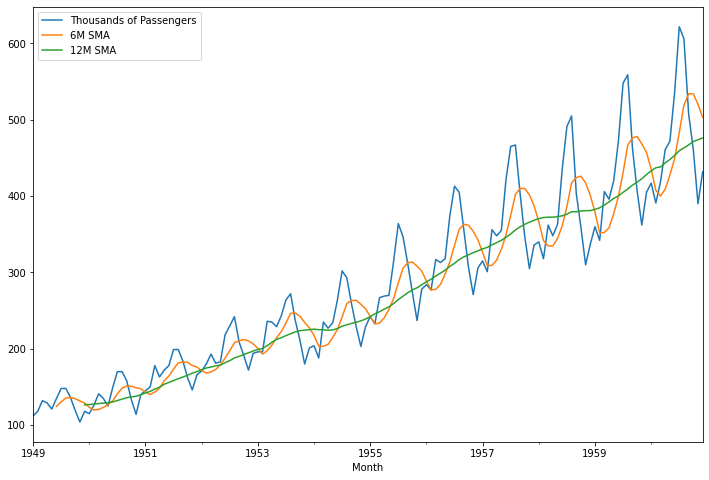

In [8]:
airline.plot(figsize=(12,8))

In [17]:
# residual을 구하기 위해서는 sklearn의 mean_squared_error를 이용하면된다.
## 임의로 결측치를 평균값으로 채워넣고 해본다..(원래는 이렇게 하면 안될듯)
airline_N=airline.fillna(airline.mean())
airline_N['6M SMA'] = airline_N['Thousands of Passengers'].rolling(window=6).mean()
## 6MA는 앞쪽 6개가 다시 결측치가 되므로, 이를 평균으로 채워줘본다..(원래는 이렇게 하면 안될듯)
airline_N=airline_N.fillna(airline.mean())

# sklearn으로 MSE를 구한다.
from sklearn.metrics import mean_squared_error
mean_squared_error(airline_N['Thousands of Passengers'], airline_N['6M SMA'])


2885.0254117249765

## Weighted Moving Average
- 단순 평균은 트렌드를 늦게 반영하고, 극단값을 쫓아가지 못함.
- 최근의 값일수록 weight를 더 높게 줌.

In [18]:
airline['WMA12'] = airline['Thousands of Passengers'].ewm(span=12).mean()
airline['WMA6'] = airline['Thousands of Passengers'].ewm(span=6).mean()

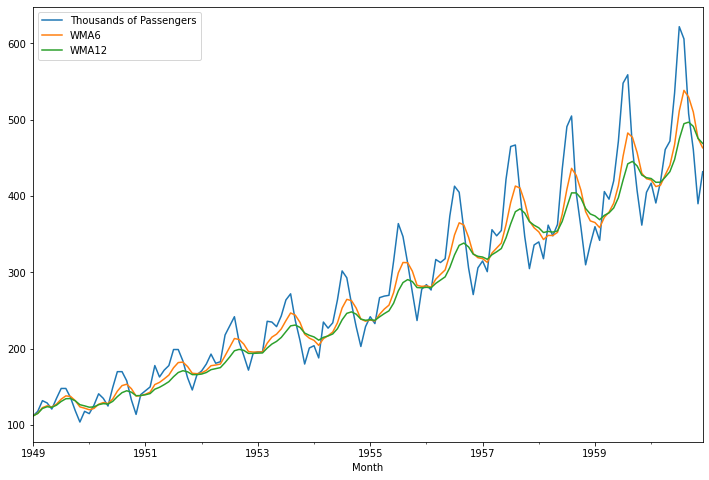

In [19]:
# 아래 그림을 통해 SMA보다 lagging이 덜한 것을 볼 수 있음.
# 즉, 원래 데이터를 잘 따라가는 것을 볼 수 있다.
airline[['Thousands of Passengers', 'WMA6','WMA12']].plot(figsize=(12,8))

## Exponential Smoothing

###Simple Exponential Smoothing
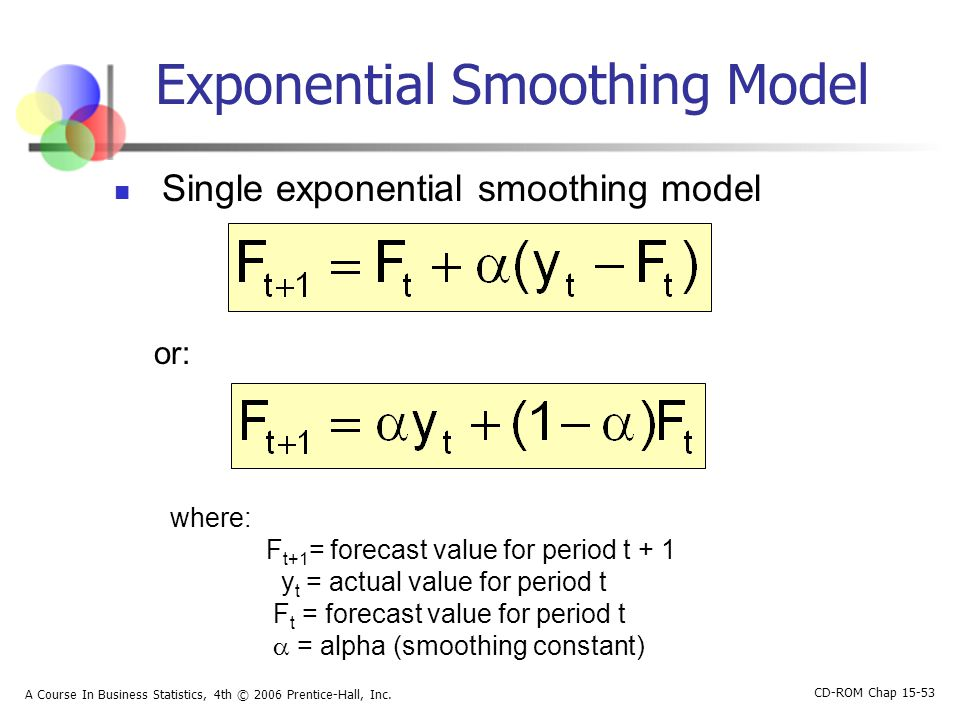

- 위의 두 식 중 아래에 대해서 F_t는 또한 F_t-1에 대해서 1-a를 포함한 식으로 만들 수 있으므로, 1-a에 대한 exponential이 만들어진다.
- Moving average들은 예측 residual이 꽤 크다. SES도 마찬가진데, 이 모델들은 trend와 seasonality를 반영을 못해준다.
- 따라서 이를 보완해주기 위해, Holt's exponential smoothing이란게 있는데, 이것은 trend까지도 반영해준다.
- Holt-Winters method의 경우, seasonality까지도 반영해준다. (즉, Holt-Winters method가 prediction이 제일 좋다.)

In [20]:
from statsmodels.tsa.api import SimpleExpSmoothing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
train = airline[:'1959']
test = airline['1960':]

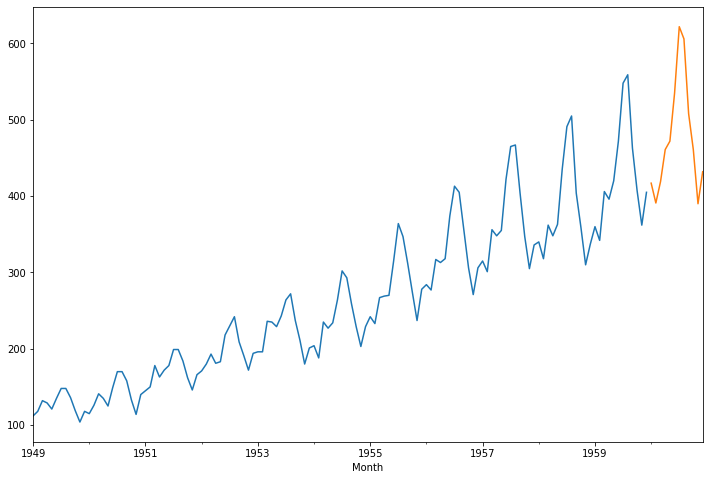

In [22]:
# 주황색이 test data이자, 우리가 예측할 부분.
train['Thousands of Passengers'].plot(figsize=(12,8))
test['Thousands of Passengers'].plot()

In [23]:
ses_model = SimpleExpSmoothing(np.asarray(train['Thousands of Passengers']))

In [24]:
#ses_model 이라는 instance를 학습시킨다.
ses_result = ses_model.fit()

In [25]:
# test data를 변형시키지 않고, 예측 데이터를 만들기 위해 y_hat을 새로 만들어준다.
y_hat = test.copy()

In [26]:
# 예측은 forcast함수를 이용한다.
# 비교할대상이 test data니까, test data의 갯수만큼 forcast한다.
# y_hat에 'SES' 컬럼으로 저장해준다.
y_hat['SES'] = ses_result.forecast(len(test))

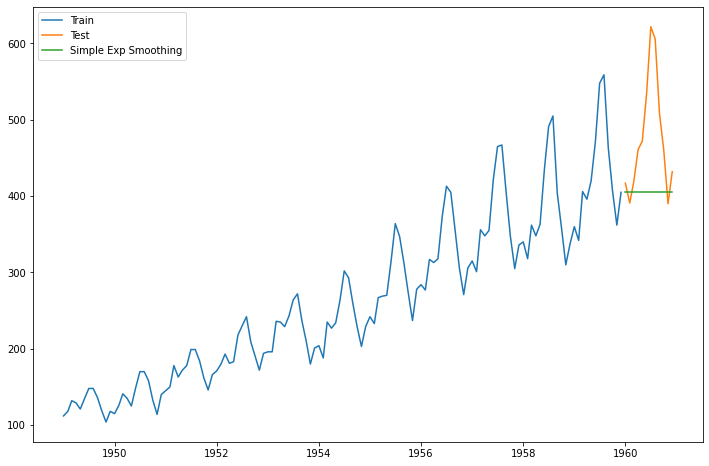

In [27]:
# 예측결과는, trend나 seasonality는 반영이 되지 않은, 이정도 y값일 것이다 정도..
plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['SES'], label='Simple Exp Smoothing')
plt.legend()

In [28]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['SES']))

In [29]:
rmse

102.97653454387881

### Holt's Method

In [30]:
from statsmodels.tsa.api import Holt

In [31]:
holt_model = Holt(np.asarray(train['Thousands of Passengers']))

In [32]:
holt_result = holt_model.fit()

In [33]:
y_hat['HOLT'] = holt_result.forecast(len(test))

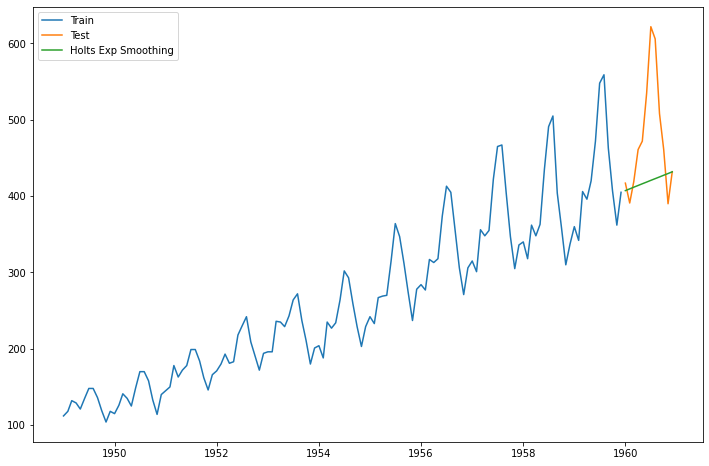

In [34]:
# SES보다는 Trend를 반영해서 선이 '우상향'으로 바뀐 것을 확인할 수 있다.
plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['HOLT'], label='Holts Exp Smoothing')
plt.legend()

In [35]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'], y_hat['HOLT']))

In [36]:
# Trend를 forecast하게 된만큼, rmse가 줄어든 것을 확인할 수 있다.
rmse

92.66641919109207

### Holt-Winters Method

In [37]:
from statsmodels.tsa.api import ExponentialSmoothing

In [38]:
# Seasonality를 파악하기 위해 parameter를 넣어줘야한다. 
# 이 data는 월간데이터니까 12개월 주기이다.
# trend와 seasonal은 additive model로 한다.
winter_model = ExponentialSmoothing(
    np.asarray(train['Thousands of Passengers']),
    seasonal_periods=12, trend='add', seasonal='add'
)

In [39]:
winter_result = winter_model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [40]:
y_hat['WINTER'] = winter_result.forecast(len(test))

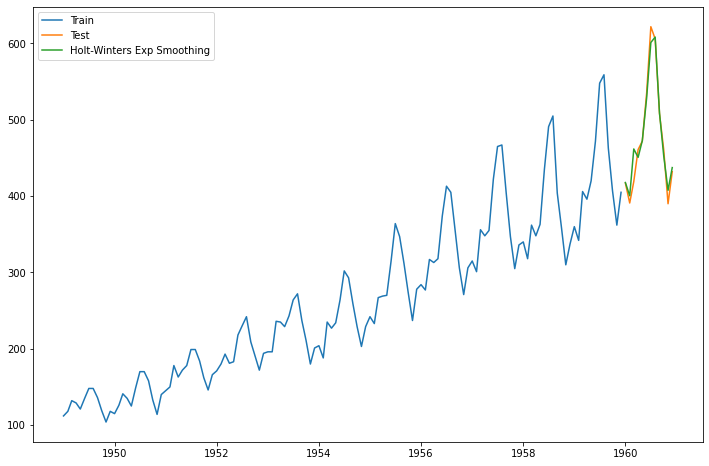

In [41]:
plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['WINTER'], label='Holt-Winters Exp Smoothing')
plt.legend()

In [42]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'],y_hat['WINTER']))

In [43]:
rmse

15.570830861607387

## ARIMA

In [ ]:
import statsmodels.api as sm

In [ ]:
# ARIMA(p,d,q)(P,D,Q)m

arima = sm.tsa.statespace.SARIMAX(train['Thousands of Passengers'],
                                  order=(2,1,1),
                                  seasonal_order=(0,1,0,12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

/home/lyle/anaconda3/envs/tsa/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
arima_result = arima.fit()

In [ ]:
y_hat['ARIMA'] = arima_result.predict(start='1960-01-01', end='1960-12-01', dynamic=True)

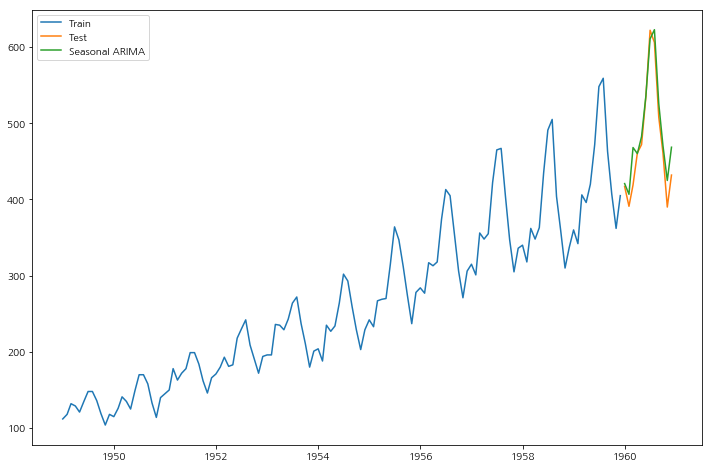

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['ARIMA'], label='Seasonal ARIMA')
plt.legend()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'],y_hat['ARIMA']))

In [ ]:
rmse

22.65096415638221